# Imports

In [2]:
import os
import requests
import datetime as dt
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import math
import statistics
from MCForecastToolsedited import MCSimulation
%matplotlib inline

In [3]:
import panel as pn
pn.extension("plotly")

In [4]:
# Load .env enviroment variables
load_dotenv()

True

---

In [5]:
#Defining a Pie Plot Function

def pie_plot_allocation(dataset):
    return dataset.plot.pie(subplots=True,
                            title="Portfolio Composition",
                            autopct='%1.0f%%',
                            fontsize=12,
                            #textprops={'color':"w"},
                            pctdistance=0.8,
                            colors=["lightblue", "lightgreen", "lightpink", "yellow"],
                            figsize=(16,6))

                                               

# Downloading Traditional Investment Data 
### Import data using pandas_datareader
### Import Traditional Asset Data - Indicies covering Stocks, Bonds & T-bills

In [6]:
assetList = ['^GSPC','^TNX', 'BND']
endDate = dt.datetime.now()
#endDate = '2021-01-22'
startDate = '2010-01-01'

#def getData_tdnl(assets, start, end):
assetData = pdr.DataReader(assetList, 'yahoo', startDate, endDate)
assetData = assetData['Close']
assetData.dropna(inplace=True)
    #return assetData
assetData.head(-1)

Symbols,^GSPC,^TNX,BND
Date,,,
2010-01-04,1132.989990,3.841,78.680000
2010-01-05,1136.520020,3.755,78.910004
2010-01-06,1137.140015,3.808,78.879997
2010-01-07,1141.689941,3.822,78.820000
2010-01-08,1144.979980,3.808,78.900002
...,...,...,...
2022-01-07,4677.029785,1.771,83.559998
2022-01-10,4670.290039,1.780,83.489998
2022-01-11,4713.069824,1.746,83.660004


### Computing daily returns on the dataset

In [7]:
assetReturns = assetData/assetData.shift(1)

#Cleaning Data
assetReturns.dropna(inplace=True)

assetReturns

Symbols,^GSPC,^TNX,BND
Date,,,
2010-01-05,1.003116,0.977610,1.002923
2010-01-06,1.000546,1.014115,0.999620
2010-01-07,1.004001,1.003676,0.999239
2010-01-08,1.002882,0.996337,1.001015
2010-01-11,1.001747,1.002626,1.000380
...,...,...,...
2022-01-10,0.998559,1.005082,0.999162
2022-01-11,1.009160,0.980899,1.002036
2022-01-12,1.002818,0.987972,0.999641


### Computing Log Returns

In [8]:
logReturns = np.log(assetReturns)

#Clean Data
logReturns.dropna(inplace=True)

logReturns

Symbols,^GSPC,^TNX,BND
Date,,,
2010-01-05,0.003111,-0.022644,0.002919
2010-01-06,0.000545,0.014016,-0.000380
2010-01-07,0.003993,0.003670,-0.000761
2010-01-08,0.002878,-0.003670,0.001014
2010-01-11,0.001745,0.002623,0.000380
...,...,...,...
2022-01-10,-0.001442,0.005069,-0.000838
2022-01-11,0.009118,-0.019286,0.002034
2022-01-12,0.002814,-0.012100,-0.000359


### DataSet Statistics for Traditional Asset Classes - Stock, Bonds, MoneyMarket

In [9]:
assetReturns.describe()

Symbols,^GSPC,^TNX,BND
count,3027.000000,3027.000000,3027.000000
mean,1.000526,1.000194,1.000022
std,0.010814,0.030291,0.002665
min,0.880159,0.706799,0.945615
25%,0.996502,0.986179,0.998729
50%,1.000703,0.999189,1.000124
75%,1.005399,1.013247,1.001405
max,1.093828,1.498998,1.042201


# Monte Carlo Simulation
### To Create Random Asset Weights for Optimum Portfolio Creation

In [10]:
#Creating random portfolios

#- How many broad assest classes to include in each portfolio
n_assets = 3

#-- How many portfolios to generate
n_portfolios = 10000

#-- Initialize empty list to store mean-variance pairs for plotting
Tweight = np.zeros((n_portfolios,n_assets))
expectedReturns = np.zeros(n_portfolios)
expectedVolatility = np.zeros(n_portfolios)
sharpeRatio = np.zeros(n_portfolios)

#Calculating Mean and Covariance
meanlogReturn = logReturns.mean()
sigma = logReturns.cov()

np.random.seed(100)
#-- Loop through and generate lots of random portfolios

for k in range(n_portfolios):
    
    #- Choose weights randomly
    Tweights = np.array(np.random.random(n_assets))
    #- Ensure weights sum to 1
    Tweights = Tweights/np.sum(Tweights)
    Tweight[k,:]=Tweights
    
    #expected Returns
    expectedReturns[k] = np.sum(meanlogReturn * Tweights)
    
    #expected volatility
    expectedVolatility[k] = np.sqrt(np.dot(Tweights.T,np.dot(sigma,Tweights)))
    
    #Sharpe Ratio
    sharpeRatio[k] = (expectedReturns[k]/expectedVolatility[k])*np.sqrt(252)

#sharpeRatio
#expectedVolatility
#expectedReturns
#weight


# Finding Optimum Portfolio Allocation - Method 1 (Random Generation)
### Finding the optimum Asset Weight, where data indicated highest return for lowest risk

In [11]:
maxIndex = sharpeRatio.argmax()
Tweight[maxIndex,:]

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data1 = (Tweight[maxIndex,:]*100)
Opt_allocation_m1=pd.DataFrame(columns =('Growth', 'Safety','Fixed Income'))
Opt_allocation_m1.loc['Random Weights'] = data1.tolist()
Opt_allocation_m1

,Growth,Safety,Fixed Income
Random Weights,46.92,0.02,53.05


array([<AxesSubplot:ylabel='Random Weights'>], dtype=object)

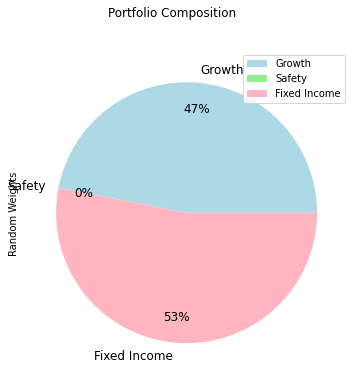

In [12]:
pie_plot_allocation(dataset=Opt_allocation_m1.T) 

# Finding Optimum Portfolio Allocation - Method 2 (Scipy Portfolio Optimizer)
### Finding the optimum Asset Weight, where data indicated highest return for lowest risk
### The method works minimizing all lesser Sharpe Ratios; equivalent to boosting higher Sharpe Ratios

In [13]:
#Efficient Frontier
from scipy.optimize import minimize

def negativeSR(Tweights):
    w = np.array(Tweights)
    r = np.sum(meanlogReturn*Tweights)
    v = np.sqrt(np.dot(Tweights.T,np.dot(sigma,Tweights)) )
    SR = r/v
    
    return -1*SR

def checkSumToOne(Tweights):
    return np.sum(Tweights)-1
    
w0 = [0.33,0.33,0.34]
bounds = ((0,1),(0,1),(0,1))
constraints = ({'type':'eq','fun':checkSumToOne})
w_opt = minimize(negativeSR,w0,method='SLSQP',bounds=bounds,constraints=constraints)
#w_opt.x

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data2 = w_opt.x*100
Opt_allocation_m2=pd.DataFrame(columns =('Growth', 'Safety','Fixed Income'))
Opt_allocation_m2.loc['Scipy Optimizer'] = data2.tolist()
Opt_allocation_m2

,Growth,Safety,Fixed Income
Scipy Optimizer,48.73,0.00,51.27


array([<AxesSubplot:ylabel='Scipy Optimizer'>], dtype=object)

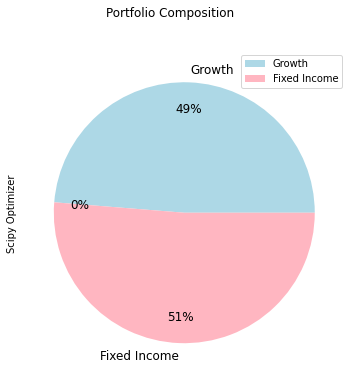

In [14]:
pie_plot_allocation(dataset=Opt_allocation_m2.T) 

# Efficient Frontier for Optimum Portfolio Allocation

In [15]:
# Holding bounds for max and min returns for line plot
upl = expectedReturns.max()
lowl = expectedReturns.min()

#Creating equal parts between upper and lower bins
returns = np.linspace(upl,lowl,50)
volatility_opt = []

def minimizemyVolatility(Tweights):
    w = np.array(Tweights)
    v = np.sqrt(np.dot(Tweights.T,np.dot(sigma,Tweights)) )
    return v

def getReturn(Tweights):
    w = np.array(Tweights)
    R = np.sum(meanlogReturn*Tweights)
    return R

for R in returns:
    #find best volatility
    constraints = ({'type':'eq','fun':checkSumToOne},
                   {'type':'eq','fun':lambda Tweights: getReturn(Tweights)-R})
    opt = minimize(minimizemyVolatility,w0,method='SLSQP',bounds=bounds,constraints=constraints)
    
    #save optimal volatility
    volatility_opt.append(opt['fun'])

#volatility_opt



# Modern Portfolio Theory - Efficient Frontier Chart

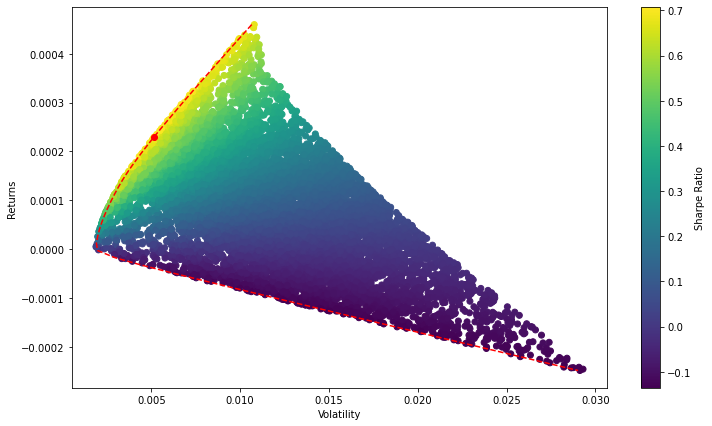

In [16]:
plt.figure(figsize=(12,7))
plt.ylabel('Returns')
plt.xlabel('Volatility')
plt.scatter(expectedVolatility,expectedReturns,c=sharpeRatio,cmap='viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(expectedVolatility[maxIndex],expectedReturns[maxIndex],c='red')
plt.plot(volatility_opt,returns,'--',c='red')
plt.show()

# Comparing Methods 1 & 2 of Optimum Portfolio Allocation

In [17]:
### Optimum Portfolio

pd.options.display.float_format = '{:,.2f}'.format
data0 = np.array([0.000001,0.00001])
data1 = (Tweight[maxIndex,:])
data2 = w_opt.x
Opt_allocation=pd.DataFrame(columns =('Growth', 'Safety','Fixed Income'))
Opt_allocation.loc['Random Weights(W1)'] = data1.tolist()
Opt_allocation.loc['Optimizer Weights(W2)'] = data2.tolist()
Opt_allocation["CCIX"] = data0
Opt_allocation_plot = Opt_allocation.transpose()
Opt_allocation_plot = Opt_allocation_plot+0.000001

## Traditional Investments - Optimum Portfolio Pie chart

array([<AxesSubplot:ylabel='Random Weights(W1)'>,
       <AxesSubplot:ylabel='Optimizer Weights(W2)'>], dtype=object)

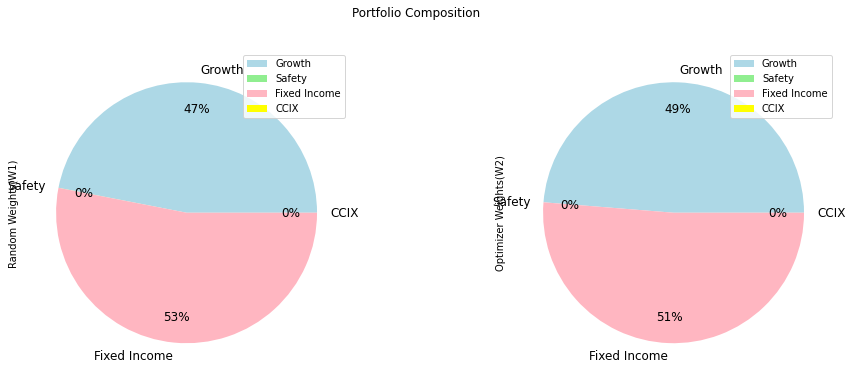

In [18]:
pie_plot_allocation(dataset=Opt_allocation_plot) 

---

# Downloading Popular Cryptocurrency Data

### Creating a Crypto Index with popular Cryptos based on MarketCap for a diversified Crypto Strategy

In [19]:
#Import data using pandas_datareader
#Import Popular Crypto Data

cryptoList = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'DOT-USD', 'SOL-USD', 'ADA-USD','DOGE-USD','XRP-USD']
endDate = dt.datetime.now()
#endDate = '2021-01-22'
startDate = '2010-01-01'

cryptoData = pdr.DataReader(cryptoList, 'yahoo', startDate, endDate)
cryptoData = cryptoData['Close']
cryptoData.dropna(inplace=True)

cryptoData.head(-1)

Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,
2020-08-20,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29
2020-08-21,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28
2020-08-22,"11,681.83",395.84,22.24,4.48,3.02,0.13,0.00,0.29
2020-08-23,"11,664.85",391.38,21.87,3.97,3.32,0.12,0.00,0.29
2020-08-24,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29
...,...,...,...,...,...,...,...,...
2021-12-31,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83
2022-01-01,"47,686.81","3,769.70",527.35,28.58,178.52,1.38,0.17,0.85
2022-01-02,"47,345.22","3,829.56",531.40,29.73,176.38,1.38,0.17,0.86


### Computing daily returns on the dataset

In [20]:
#computing daily returns on the dataset
cryptoReturns = cryptoData/cryptoData.shift(1)
#cleaning Data
cryptoReturns.dropna(inplace=True)
cryptoReturns

Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,
2020-08-21,0.98,0.93,0.96,0.99,0.92,0.93,0.98,0.96
2020-08-22,1.01,1.02,1.01,1.56,1.03,1.01,1.01,1.02
2020-08-23,1.00,0.99,0.98,0.88,1.10,0.97,0.99,1.00
2020-08-24,1.01,1.04,1.03,1.16,1.01,1.02,1.00,1.01
2020-08-25,0.97,0.94,0.95,1.20,0.98,0.91,0.97,0.96
...,...,...,...,...,...,...,...,...
2022-01-01,1.03,1.02,1.03,1.07,1.05,1.05,1.01,1.02
2022-01-02,0.99,1.02,1.01,1.04,0.99,1.00,1.01,1.01
2022-01-03,0.98,0.98,0.96,1.01,0.97,0.96,0.98,0.97


### Computing Log Returns

In [21]:
cryptologReturns = np.log(cryptoReturns)
#Cleaning data
cryptologReturns.dropna(inplace=True)

cryptologReturns

Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,
2020-08-21,-0.02,-0.07,-0.04,-0.01,-0.09,-0.08,-0.02,-0.04
2020-08-22,0.01,0.02,0.00,0.44,0.03,0.01,0.01,0.02
2020-08-23,-0.00,-0.01,-0.02,-0.12,0.10,-0.03,-0.01,-0.00
2020-08-24,0.01,0.04,0.03,0.15,0.01,0.02,0.00,0.01
2020-08-25,-0.04,-0.06,-0.05,0.18,-0.02,-0.09,-0.03,-0.04
...,...,...,...,...,...,...,...,...
2022-01-01,0.03,0.02,0.03,0.07,0.05,0.05,0.01,0.02
2022-01-02,-0.01,0.02,0.01,0.04,-0.01,0.00,0.01,0.01
2022-01-03,-0.02,-0.02,-0.04,0.01,-0.04,-0.04,-0.03,-0.03


### DataSet Statistics for Cryptocurrency Assets

In [22]:
cryptoReturns.describe()

Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
count,503.00,503.00,503.00,503.00,503.00,503.00,503.00,503.00
mean,1.00,1.01,1.01,1.01,1.01,1.01,1.02,1.01
std,0.04,0.05,0.07,0.08,0.09,0.07,0.19,0.08
min,0.86,0.73,0.67,0.62,0.63,0.74,0.60,0.58
25%,0.98,0.98,0.98,0.97,0.96,0.97,0.97,0.97
50%,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00
75%,1.02,1.03,1.03,1.04,1.05,1.03,1.02,1.03
max,1.19,1.26,1.70,1.56,1.47,1.32,4.56,1.56


# Monte Carlo Simulation
### To Create Random Asset Weights for Optimum Portfolio Creation /and Creating Optimum Index Weights

In [23]:
#Creating random crypto portfolios

#- How many assests to include in each portfolio
n_crypto = 8

#-- How many portfolios to generate
n_Cportfolios = 10000

#-- Initialize empty list to store mean-variance pairs for plotting
Cweight=np.zeros((n_Cportfolios,n_crypto))
CexpectedReturns=np.zeros(n_Cportfolios)
CexpectedVolatility=np.zeros(n_Cportfolios)
CsharpeRatio=np.zeros(n_Cportfolios)

# Computing Mean and Covariance
CmeanlogReturn = cryptologReturns.mean()
Csigma = cryptologReturns.cov()

np.random.seed(100)
#-- Loop through and generate lots of random portfolios
for k in range(n_Cportfolios):
    
    #- Choose weights randomly
    Cweights = np.array(np.random.random(n_crypto))
    #- Ensure weights sum to 1
    Cweights = Cweights/np.sum(Cweights)
    Cweight[k,:]=Cweights
    
    #expected Returns
    CexpectedReturns[k] = np.sum(CmeanlogReturn * Cweights)
    
    #expected volatility
    CexpectedVolatility[k] = np.sqrt(np.dot(Cweights.T,np.dot(Csigma,Cweights)))
    
    #Sharpe Ratio
    CsharpeRatio[k] = (CexpectedReturns[k]/CexpectedVolatility[k])*np.sqrt(365)
    
#Cweight 
#CexpectedReturns
#CexpectedVolatility
#CsharpeRatio

# Finding Optimum Portfolio Allocation - Method 1 (Random Generation)
### Finding the optimum Asset Weight, where data indicated highest return for lowest risk

In [24]:
CmaxIndex = CsharpeRatio.argmax()
Cweight[CmaxIndex,:]

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data3 = (Cweight[CmaxIndex,:]*100)
cryp_index_m1=pd.DataFrame(columns = ('Bitcoin','Ethereum',
                                   'Binance','Polkadot',
                                   'Solana','Cardano',
                                   'Dogecoin','Ripple'))
cryp_index_m1.loc['Random Weights'] = data3.tolist()
cryp_index_m1


,Bitcoin,Ethereum,Binance,Polkadot,Solana,Cardano,Dogecoin,Ripple
Random Weights,4.66,0.76,30.27,1.38,27.92,5.26,27.02,2.73


array([<AxesSubplot:ylabel='Random Weights'>], dtype=object)

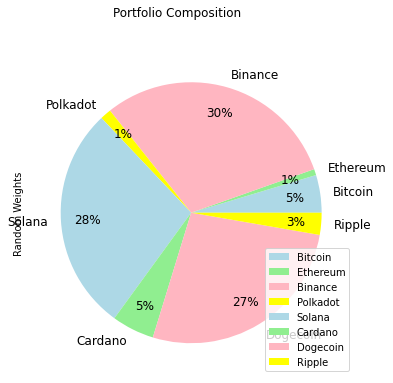

In [25]:
pie_plot_allocation(dataset=cryp_index_m1.T) 

# Finding Optimum Portfolio Allocation - Method 2 (Scipy Portfolio Optimizer)
### Finding the optimum Asset Weight, where data indicated highest return for lowest risk
### The method works minimizing all lesser Sharpe Ratios; equivalent to boosting higher Sharpe Ratios

In [26]:
#Efficient Frontier
from scipy.optimize import minimize

def CnegativeSR(Cweights):
    Cw = np.array(Cweights)
    Cr = np.sum(CmeanlogReturn*Cweights)
    Cv = np.sqrt(np.dot(Cweights.T,np.dot(Csigma,Cweights)) )
    CSR = Cr/Cv
    
    return -1*CSR

def CcheckSumToOne(Cweights):
    return np.sum(Cweights)-1
    
Cw0 = [0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125]
Cbounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
Cconstraints = ({'type':'eq','fun':CcheckSumToOne})
Cw_opt = minimize(CnegativeSR,Cw0,method='SLSQP',bounds=Cbounds,constraints=Cconstraints)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
Cw_opt.x*100

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data4 = Cw_opt.x*100
cryp_index_m2=pd.DataFrame(columns = ('Bitcoin','Ethereum',
                                   'Binance','Polkadot',
                                   'Solana','Cardano',
                                   'Dogecoin','Ripple'))
cryp_index_m2.loc['Scipy Optimizer'] = data4.tolist()
cryp_index_m2

,Bitcoin,Ethereum,Binance,Polkadot,Solana,Cardano,Dogecoin,Ripple
Scipy Optimizer,0.00,0.00,43.33,0.00,32.98,2.95,20.75,0.00


array([<AxesSubplot:ylabel='Scipy Optimizer'>], dtype=object)

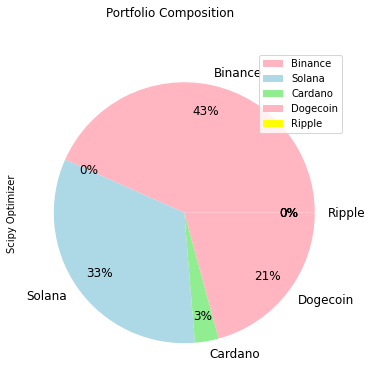

In [27]:
pie_plot_allocation(dataset=cryp_index_m2.T) 

# Efficient Frontier for Optimum Portfolio Allocation

In [28]:
# Holding bounds for max and min returns for line plot
Cupl = CexpectedReturns.max()
Clowl = CexpectedReturns.min()

#Creating equal parts between upper and lower bins
Creturns = np.linspace(Clowl,Cupl,50)
Cvolatility_opt = []

def CminimizemyVolatility(Cweights):
    Cw = np.array(Cweights)
    Cv = np.sqrt(np.dot(Cweights.T,np.dot(Csigma,Cweights)) )
    return Cv

def CgetReturn(Cweights):
    Cw = np.array(Cweights)
    CR = np.sum(CmeanlogReturn*Cweights)
    return CR

for R in Creturns:
    #find best volatility
    Cconstraints = ({'type':'eq','fun':CcheckSumToOne},
                   {'type':'eq','fun':lambda Cweights: CgetReturn(Cweights)-R})
    Copt = minimize(CminimizemyVolatility,Cw0,method='SLSQP',bounds=Cbounds,constraints=Cconstraints)
    
    #save optimal volatility
    Cvolatility_opt.append(Copt['fun'])
#Cvolatility_opt

# Modern Portfolio Theory - Efficient Frontier Chart

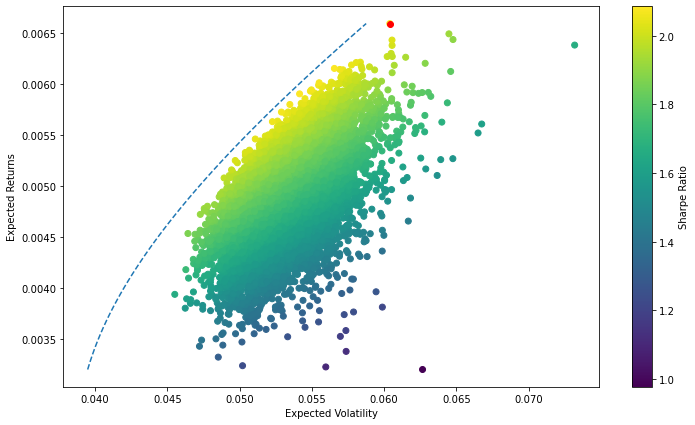

In [29]:
plt.figure(figsize=(12,7))
plt.ylabel('Expected Returns')
plt.xlabel('Expected Volatility')
plt.scatter(CexpectedVolatility,CexpectedReturns,c=CsharpeRatio,cmap='viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(CexpectedVolatility[CmaxIndex],CexpectedReturns[CmaxIndex],c='red')
plt.plot(Cvolatility_opt,Creturns,'--')
plt.show()

# Comparing Methods 1 & 2 of Optimum Portfolio Allocation

### Optimum Portfolio

In [30]:
#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data3 = (Cweight[CmaxIndex,:])
data4 = Cw_opt.x
cryp_index=pd.DataFrame(columns = ('Bitcoin','Ethereum',
                                   'Binance','Polkadot',
                                   'Solana','Cardano',
                                   'Dogecoin','Ripple'))
cryp_index.loc['Random Weights'] = data3.tolist()
cryp_index.loc['Optimizer Weights'] = data4.tolist()
cryp_index_plot = cryp_index.transpose()
cryp_index_plot

,Random Weights,Optimizer Weights
Bitcoin,0.05,0.00
Ethereum,0.01,0.00
Binance,0.30,0.43
Polkadot,0.01,0.00
Solana,0.28,0.33
Cardano,0.05,0.03
Dogecoin,0.27,0.21
Ripple,0.03,0.00


### Cryto Index Pie Chart

array([<AxesSubplot:ylabel='Random Weights'>,
       <AxesSubplot:ylabel='Optimizer Weights'>], dtype=object)

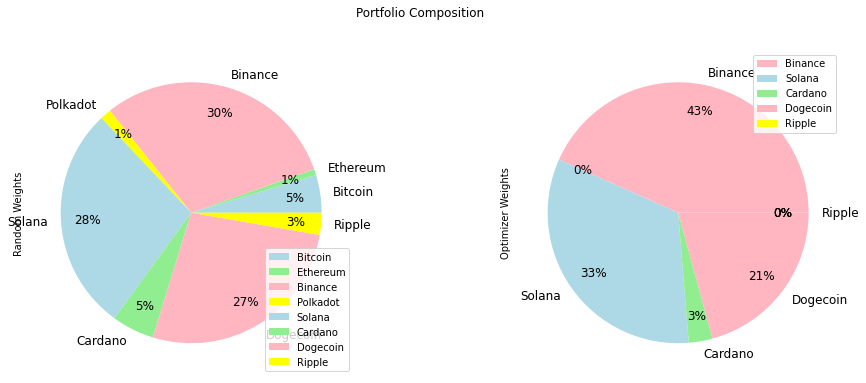

In [31]:
pie_plot_allocation(dataset=cryp_index.T) 

---

# Combined Portfolio - Traditional + Crypto
### Finding a possible optimum portfolio with Traditional Investment Classes and a Crypto Index

## Concat Traditional Investment Data + Crypto Data
#### Result is a sample of available data 
### Import Traditional Asset Data - Indicies covering Stocks, Bonds, T-bills and Cryptocurrencies

In [32]:
combined_data = pd.concat([assetData,cryptoData],axis=1,
    join="inner")
combined_data

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,,,,
2020-08-20,"3,385.51",0.64,88.58,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29
2020-08-21,"3,397.16",0.64,88.77,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28
2020-08-24,"3,431.28",0.65,88.67,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29
2020-08-25,"3,443.62",0.68,88.50,"11,366.13",384.00,21.48,5.52,3.26,0.11,0.00,0.28
2020-08-26,"3,478.73",0.69,88.45,"11,488.36",386.47,22.28,6.08,3.56,0.12,0.00,0.28
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"46,444.71","3,628.53",514.00,26.74,170.66,1.33,0.17,0.82
2021-12-30,"4,778.73",1.51,84.77,"47,178.12","3,713.85",518.91,27.57,172.75,1.36,0.17,0.84
2021-12-31,"4,766.18",1.51,84.75,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83


### Computing daily returns on the dataset

In [33]:
#computing daily returns on the dataset
combined_returns = combined_data/combined_data.shift(1)
#cleaning Data
combined_returns.dropna(inplace=True)
combined_returns

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,,,,
2020-08-21,1.00,0.99,1.00,0.98,0.93,0.96,0.99,0.92,0.93,0.98,0.96
2020-08-24,1.01,1.01,1.00,1.02,1.05,1.02,1.60,1.14,1.01,1.01,1.03
2020-08-25,1.00,1.06,1.00,0.97,0.94,0.95,1.20,0.98,0.91,0.97,0.96
2020-08-26,1.01,1.01,1.00,1.01,1.01,1.04,1.10,1.09,1.02,1.00,1.00
2020-08-27,1.00,1.09,1.00,0.99,0.99,1.04,0.93,0.97,0.93,0.97,0.95
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,1.00,1.04,1.00,0.98,0.95,0.96,0.96,0.96,0.95,0.96,0.96
2021-12-30,1.00,0.98,1.00,1.02,1.02,1.01,1.03,1.01,1.02,1.02,1.03
2021-12-31,1.00,1.00,1.00,0.98,0.99,0.99,0.97,0.99,0.96,1.00,0.99


## Adding a new Crypto Index (CCIX)
### Selected Cryptos * Optimized Crypto Weights 

### Crypto Weights (Arbitrarily choosing Random Weights for CCIX allocation)

In [34]:
cryp_index

,Bitcoin,Ethereum,Binance,Polkadot,Solana,Cardano,Dogecoin,Ripple
Random Weights,0.05,0.01,0.30,0.01,0.28,0.05,0.27,0.03
Optimizer Weights,0.00,0.00,0.43,0.00,0.33,0.03,0.21,0.00


### Creating CCIX Market Value based on Price*Weights

In [35]:
CCIX_val = ((combined_data['BTC-USD']*cryp_index['Bitcoin'].loc["Random Weights"])+
            (combined_data['ETH-USD']*cryp_index['Ethereum'].loc["Random Weights"])+
            (combined_data['BNB-USD']*cryp_index['Binance'].loc["Random Weights"])+
            (combined_data['DOT-USD']*cryp_index['Polkadot'].loc["Random Weights"])+
            (combined_data['SOL-USD']*cryp_index['Solana'].loc["Random Weights"])+
            (combined_data['ADA-USD']*cryp_index['Cardano'].loc["Random Weights"])+
            (combined_data['DOGE-USD']*cryp_index['Dogecoin'].loc["Random Weights"])+
            (combined_data['XRP-USD']*cryp_index['Ripple'].loc["Random Weights"]))

In [36]:
combined_data["CCIX"] = CCIX_val
combined_data

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD,CCIX
Date,,,,,,,,,,,,
2020-08-20,"3,385.51",0.64,88.58,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29,564.94
2020-08-21,"3,397.16",0.64,88.77,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28,551.03
2020-08-24,"3,431.28",0.65,88.67,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29,559.95
2020-08-25,"3,443.62",0.68,88.50,"11,366.13",384.00,21.48,5.52,3.26,0.11,0.00,0.28,540.37
2020-08-26,"3,478.73",0.69,88.45,"11,488.36",386.47,22.28,6.08,3.56,0.12,0.00,0.28,546.42
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"46,444.71","3,628.53",514.00,26.74,170.66,1.33,0.17,0.82,"2,396.76"
2021-12-30,"4,778.73",1.51,84.77,"47,178.12","3,713.85",518.91,27.57,172.75,1.36,0.17,0.84,"2,433.69"
2021-12-31,"4,766.18",1.51,84.75,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83,"2,389.93"


In [37]:
CCIX_WG = ((combined_returns['BTC-USD']*cryp_index['Bitcoin'].loc["Random Weights"])+
            (combined_returns['ETH-USD']*cryp_index['Ethereum'].loc["Random Weights"])+
            (combined_returns['BNB-USD']*cryp_index['Binance'].loc["Random Weights"])+
            (combined_returns['DOT-USD']*cryp_index['Polkadot'].loc["Random Weights"])+
            (combined_returns['SOL-USD']*cryp_index['Solana'].loc["Random Weights"])+
            (combined_returns['ADA-USD']*cryp_index['Cardano'].loc["Random Weights"])+
            (combined_returns['DOGE-USD']*cryp_index['Dogecoin'].loc["Random Weights"])+
            (combined_returns['XRP-USD']*cryp_index['Ripple'].loc["Random Weights"]))

In [38]:
#CCIX_WG to store the returns

In [39]:
combined_returns["CCIX"] = CCIX_WG
combined_returns

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD,CCIX
Date,,,,,,,,,,,,
2020-08-21,1.00,0.99,1.00,0.98,0.93,0.96,0.99,0.92,0.93,0.98,0.96,0.95
2020-08-24,1.01,1.01,1.00,1.02,1.05,1.02,1.60,1.14,1.01,1.01,1.03,1.06
2020-08-25,1.00,1.06,1.00,0.97,0.94,0.95,1.20,0.98,0.91,0.97,0.96,0.96
2020-08-26,1.01,1.01,1.00,1.01,1.01,1.04,1.10,1.09,1.02,1.00,1.00,1.04
2020-08-27,1.00,1.09,1.00,0.99,0.99,1.04,0.93,0.97,0.93,0.97,0.95,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,1.00,1.04,1.00,0.98,0.95,0.96,0.96,0.96,0.95,0.96,0.96,0.96
2021-12-30,1.00,0.98,1.00,1.02,1.02,1.01,1.03,1.01,1.02,1.02,1.03,1.02
2021-12-31,1.00,1.00,1.00,0.98,0.99,0.99,0.97,0.99,0.96,1.00,0.99,0.99


## New Combined Data Set
#### Dropping individual Cryptos and keeping the new Crypto Index (CCIX)

In [40]:
#New Combined Data with Price/Values
new_combinedData = combined_data.drop(["BTC-USD","ETH-USD","BNB-USD","DOT-USD","SOL-USD","ADA-USD","DOGE-USD","XRP-USD"],axis=1)
new_combinedData

Symbols,^GSPC,^TNX,BND,CCIX
Date,,,,
2020-08-20,"3,385.51",0.64,88.58,564.94
2020-08-21,"3,397.16",0.64,88.77,551.03
2020-08-24,"3,431.28",0.65,88.67,559.95
2020-08-25,"3,443.62",0.68,88.50,540.37
2020-08-26,"3,478.73",0.69,88.45,546.42
...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"2,396.76"
2021-12-30,"4,778.73",1.51,84.77,"2,433.69"
2021-12-31,"4,766.18",1.51,84.75,"2,389.93"


In [41]:
#New Combined Data with Returns
new_combinedReturns = combined_returns.drop(["BTC-USD","ETH-USD","BNB-USD","DOT-USD","SOL-USD","ADA-USD","DOGE-USD","XRP-USD"],axis=1)
new_combinedReturns

Symbols,^GSPC,^TNX,BND,CCIX
Date,,,,
2020-08-21,1.00,0.99,1.00,0.95
2020-08-24,1.01,1.01,1.00,1.06
2020-08-25,1.00,1.06,1.00,0.96
2020-08-26,1.01,1.01,1.00,1.04
2020-08-27,1.00,1.09,1.00,0.99
...,...,...,...,...
2021-12-29,1.00,1.04,1.00,0.96
2021-12-30,1.00,0.98,1.00,1.02
2021-12-31,1.00,1.00,1.00,0.99


### DataSet Statistics for Cryptocurrency Assets

In [42]:
new_combinedReturns.describe()

Symbols,^GSPC,^TNX,BND,CCIX
count,346.00,346.00,346.00,346.00
mean,1.00,1.00,1.00,1.02
std,0.01,0.03,0.00,0.09
min,0.96,0.87,0.99,0.68
25%,1.00,0.98,1.00,0.97
50%,1.00,1.00,1.00,1.01
75%,1.01,1.02,1.00,1.05
max,1.02,1.17,1.01,2.00


### Computing log returns on the dataset

In [43]:
new_logcombinedReturns = np.log(new_combinedReturns)
#Cleaning data
new_logcombinedReturns.dropna(inplace=True)

new_logcombinedReturns

Symbols,^GSPC,^TNX,BND,CCIX
Date,,,,
2020-08-21,0.00,-0.01,0.00,-0.05
2020-08-24,0.01,0.01,-0.00,0.06
2020-08-25,0.00,0.05,-0.00,-0.04
2020-08-26,0.01,0.01,-0.00,0.04
2020-08-27,0.00,0.08,-0.00,-0.01
...,...,...,...,...
2021-12-29,0.00,0.04,-0.00,-0.04
2021-12-30,-0.00,-0.02,0.00,0.02
2021-12-31,-0.00,-0.00,-0.00,-0.01


# Monte Carlo Simulation
### To Create Random Asset Weights for Optimum Portfolio Weights for Traditional + Crypto Assets

In [44]:
#Creating random crypto portfolios

#- How many assests to include in each portfolio
n_TC = 4

#-- How many portfolios to generate
n_TCportfolios = 10000

#-- Initialize empty list to store mean-variance pairs for plotting
TCweight=np.zeros((n_TCportfolios,n_TC))
TCexpectedReturns=np.zeros(n_TCportfolios)
TCexpectedVolatility=np.zeros(n_TCportfolios)
TCsharpeRatio=np.zeros(n_TCportfolios)

# Computing Mean and Covariance
TCmeanlogReturn = new_logcombinedReturns.mean()
TCsigma = new_logcombinedReturns.cov()

np.random.seed(100)
#-- Loop through and generate lots of random portfolios
for k in range(n_TCportfolios):
    
    #- Choose weights randomly
    TCweights = np.array(np.random.random(n_TC))
    #- Ensure weights sum to 1
    TCweights = TCweights/np.sum(TCweights)
    TCweight[k,:]=TCweights
    
    #expected Returns
    TCexpectedReturns[k] = np.sum(TCmeanlogReturn * TCweights)
    
    #expected volatility
    TCexpectedVolatility[k] = np.sqrt(np.dot(TCweights.T,np.dot(TCsigma,TCweights)))
    
    #Sharpe Ratio
    TCsharpeRatio[k] = (TCexpectedReturns[k]/TCexpectedVolatility[k])*np.sqrt(365)
    
#Cweight 
#CexpectedReturns
#CexpectedVolatility
#CsharpeRatio

# Finding Optimum Portfolio Allocation - Method 1 (Random Generation)
### Finding the optimum Asset Weight, where data indicated highest return for lowest risk

In [45]:
TCmaxIndex = TCsharpeRatio.argmax()
TCweight[TCmaxIndex,:]*100

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data5 = (TCweight[TCmaxIndex,:]*100)
TC_index_m1=pd.DataFrame(columns = ('S&P 500','T-BILL',
                                   'BOND INDEX','CCIX'))
TC_index_m1.loc['Random Weights'] = data5.tolist()
TC_index_m1

,S&P 500,T-BILL,BOND INDEX,CCIX
Random Weights,64.55,17.88,1.81,15.77


# Finding Optimum Portfolio Allocation - Method 2 (Scipy Portfolio Optimizer)
### Finding the optimum Asset Weight, where data indicated highest return for lowest risk
### The method works minimizing all lesser Sharpe Ratios; equivalent to boosting higher Sharpe Ratios

In [46]:
#Efficient Frontier
from scipy.optimize import minimize

def TCnegativeSR(TCweights):
    TCw = np.array(TCweights)
    TCr = np.sum(TCmeanlogReturn*TCweights)
    TCv = np.sqrt(np.dot(TCweights.T,np.dot(TCsigma,TCweights)) )
    TCSR = TCr/TCv
    
    return -1*TCSR

def TCcheckSumToOne(TCweights):
    return np.sum(TCweights)-1
    
TCw0 = [0.25,0.25,0.25,0.25]
TCbounds = ((0,1),(0,1),(0,1),(0,1))
TCconstraints = ({'type':'eq','fun':TCcheckSumToOne})
TCw_opt = minimize(TCnegativeSR,TCw0,method='SLSQP',bounds=TCbounds,constraints=TCconstraints)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
TCw_opt.x*100

#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data6 = TCw_opt.x*100
TC_index_m2=pd.DataFrame(columns = ('S&P 500','T-BILL',
                                   'BOND INDEX','CCIX'))
TC_index_m2.loc['Optimizer Weights'] = data6.tolist()
TC_index_m2

,S&P 500,T-BILL,BOND INDEX,CCIX
Optimizer Weights,65.67,18.15,0.00,16.18


# Efficient Frontier for Optimum Portfolio Allocation

In [47]:
# Holding bounds for max and min returns for line plot
TCupl = TCexpectedReturns.max()
TClowl = TCexpectedReturns.min()

#Creating equal parts between upper and lower bins
TCreturns = np.linspace(TCupl,TClowl,50)
TCvolatility_opt = []

def TCminimizemyVolatility(TCweights):
    TCw = np.array(TCweights)
    TCv = np.sqrt(np.dot(TCweights.T,np.dot(TCsigma,TCweights)) )
    return TCv

def TCgetReturn(TCweights):
    TCw = np.array(TCweights)
    TCR = np.sum(TCmeanlogReturn*TCweights)
    return TCR

for R in TCreturns:
    #find best volatility
    TCconstraints = ({'type':'eq','fun':TCcheckSumToOne},
                   {'type':'eq','fun':lambda TCweights: TCgetReturn(TCweights)-R})
    TCopt = minimize(TCminimizemyVolatility,TCw0,method='SLSQP',bounds=TCbounds,constraints=TCconstraints)
    
    #save optimal volatility
    TCvolatility_opt.append(TCopt['fun'])
#TCvolatility_opt

# Modern Portfolio Theory - Efficient Frontier Chart

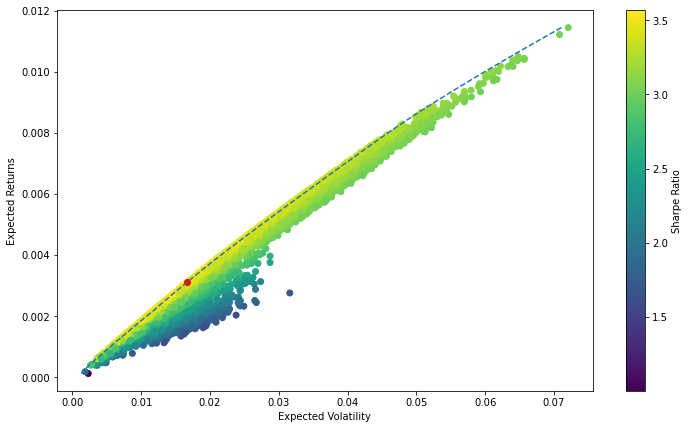

In [48]:
def eff_front ():
    plt.figure(figsize=(12,7))
    plt.ylabel('Expected Returns')
    plt.xlabel('Expected Volatility')
    plt.scatter(TCexpectedVolatility,TCexpectedReturns,c=TCsharpeRatio,cmap='viridis')
    plt.colorbar(label = 'Sharpe Ratio')
    plt.scatter(TCexpectedVolatility[TCmaxIndex],TCexpectedReturns[TCmaxIndex],c='red')
    plt.plot(TCvolatility_opt,TCreturns,'--')
    plt.show()
    return

# Comparing Methods 1 & 2 of Optimum Portfolio Allocation

In [55]:
#Publishing Data in Data Frame
pd.options.display.float_format = '{:,.2f}'.format
data5 = (TCweight[TCmaxIndex,:])
data6 = TCw_opt.x
TC_index=pd.DataFrame(columns = ('Growth','Safety',
                                   'Fixed Income','CCIX'))
TC_index.loc['Random Weights(W5)'] = data5.tolist()
TC_index.loc['Optimizer Weights(W6)'] = data6.tolist()
TC_index_plot=TC_index.transpose()
TC_index_plot

,Random Weights(W5),Optimizer Weights(W6)
Growth,0.65,0.66
Safety,0.18,0.18
Fixed Income,0.02,0.00
CCIX,0.16,0.16


### Combined allocation Pie Chart ??

array([<AxesSubplot:ylabel='Random Weights(W5)'>,
       <AxesSubplot:ylabel='Optimizer Weights(W6)'>], dtype=object)

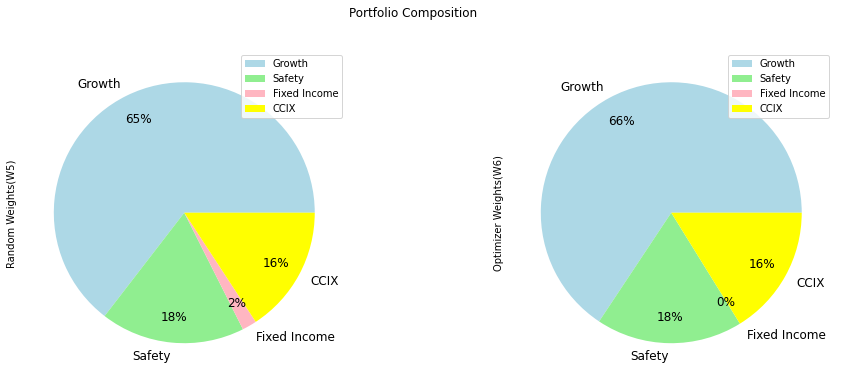

In [56]:
pie_plot_allocation(dataset=TC_index.T) 


---

# Financial Planner

In [57]:
#Variables to Store Weights
w1 = data1
w2 = data2
w3 = data3
w4 = data4
w5 = data5
w6 = data6
equal = [0.25,0.25,0.25,0.25]
stock_only = [1,0,0,0]
crypto_index = [0,0,0,1]

## All computed allocations

In [58]:
#Traditional Investments Allocation
Opt_allocation

,Growth,Safety,Fixed Income,CCIX
Random Weights(W1),0.47,0.00,0.53,0.00
Optimizer Weights(W2),0.49,0.00,0.51,0.00


In [59]:
#CCIX Allocation
cryp_index

,Bitcoin,Ethereum,Binance,Polkadot,Solana,Cardano,Dogecoin,Ripple
Random Weights,0.05,0.01,0.30,0.01,0.28,0.05,0.27,0.03
Optimizer Weights,0.00,0.00,0.43,0.00,0.33,0.03,0.21,0.00


In [84]:
#Traditional + Crypto Allocation Optimum comuted allocation
TC_index

,Growth,Safety,Fixed Income,CCIX
Random Weights(W5),0.65,0.18,0.02,0.16
Optimizer Weights(W6),0.66,0.18,0.00,0.16


### Dataset compatible with Financial Planner & MCForecastTools

In [61]:
new_combinedData_ml=pd.DataFrame(new_combinedData)
new_combinedData_ml.columns = pd.MultiIndex.from_product([['S&P500','T-Bill','Fixed Income','CCIX'],list('C')])

new_combinedData_ml.rename({'C': 'close'}, axis=1, inplace=True)
new_combinedData_ml


,S&P500,T-Bill,Fixed Income,CCIX
,close,close,close,close
Date,,,,
2020-08-20,"3,385.51",0.64,88.58,564.94
2020-08-21,"3,397.16",0.64,88.77,551.03
2020-08-24,"3,431.28",0.65,88.67,559.95
2020-08-25,"3,443.62",0.68,88.50,540.37
2020-08-26,"3,478.73",0.69,88.45,546.42
...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"2,396.76"
2021-12-30,"4,778.73",1.51,84.77,"2,433.69"


### Financial Planner Function

In [62]:
w1 = Opt_allocation.loc['Random Weights(W1)'].tolist()
w2 = Opt_allocation.loc['Optimizer Weights(W2)'].tolist()
w3 = data3
w4 = data4
w5 = TC_index.loc['Random Weights(W5)'].tolist()
w6 = TC_index.loc['Optimizer Weights(W6)'].tolist()
equal = [0.25,0.25,0.25,0.25]
stock_only = [1,0,0,0]
CCIX_only = [0,0,0,1]
years = 1
initial_investment = 10000

In [83]:
def plan_print_summary(data, weights, years, investment):    
    # Configuring a Monte Carlo simulation to forecast cumulative returns
    plan = MCSimulation(
    portfolio_data = new_combinedData_ml,
    weights = weights,
    num_simulation = 5,
    num_trading_days = 252*years
    )

    # Running a Monte Carlo simulation to forecast cumulative returns
    np.random.seed(100)
    
    # Fetch summary statistics from the Monte Carlo simulation results
    plan_summary = plan.summarize_cumulative_return()
    
    # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of an initial investment
    ci_lower1 = plan_summary[8]*initial_investment
    ci_upper1 = plan_summary[9]*initial_investment
    
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
       f" over the next {years} year(s) will end within in the range of"
       f" ${ci_lower1:,.2f} and ${ci_upper1:,.2f}")
          
    return

plan_print_summary(data=new_combinedData_ml, weights = w6, years = 3, investment = 10000)

There is a 95% chance that an initial investment of $10,000.00 in the portfolio over the next 3 year(s) will end within in the range of $31,505.31 and $83,049.21


In [64]:
def cumulative_returns_plot(data, weights, years, investment):    
    # Configuring a Monte Carlo simulation to forecast cumulative returns
    plan = MCSimulation(
    portfolio_data = new_combinedData_ml,
    weights = weights,
    num_simulation = 5,
    num_trading_days = 252*years
    )

    # Running a Monte Carlo simulation to forecast cumulative returns
    np.random.seed(100)
    
    # Plot simulation outcomes
    plan.calc_cumulative_return()
    return

cumulative_returns_plot(data=new_combinedData_ml, weights = stock_only, years = 1, investment = 10000)

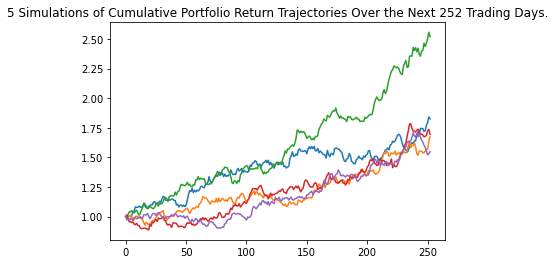

In [68]:
def line_plot(data, weights, years, investment):    
    # Configuring a Monte Carlo simulation to forecast cumulative returns
    plan = MCSimulation(
    portfolio_data = new_combinedData_ml,
    weights = weights,
    num_simulation = 5,
    #groupby = weights,
    num_trading_days = 252*years
    )

    # Running a Monte Carlo simulation to forecast cumulative returns
    np.random.seed(100)
    
    # Plot simulation outcomes
    plan.calc_cumulative_return()
    
    # Plot simulation outcomes
    line_plot_plan = plan.plot_simulation() 
    return
    
line_plot(data=new_combinedData_ml, weights = equal, years = 1, investment = 10000)    

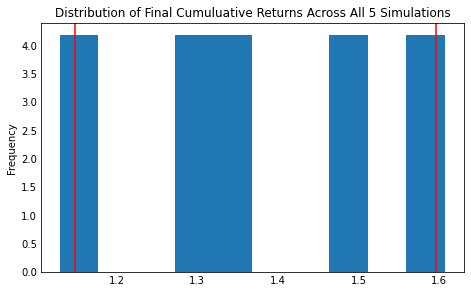

In [464]:
def bar_plot(data, weights, years, investment):    
    # Configuring a Monte Carlo simulation to forecast cumulative returns
    plan = MCSimulation(
    portfolio_data = new_combinedData_ml,
    weights = weights,
    num_simulation = 5,
    num_trading_days = 252*years
    )

    # Running a Monte Carlo simulation to forecast cumulative returns
    np.random.seed(100)
    
    # Plot probability distribution and confidence intervals
    dist_plot_plan = plan.plot_distribution()
    
    return

bar_plot(data=new_combinedData_ml, weights = stock_only, years = 1, investment = 10000)
    

In [465]:
# def new_fin_planner(data, weights, years, investment):
    
#     # Configuring a Monte Carlo simulation to forecast cumulative returns
#     plan = MCSimulation(
#     portfolio_data = new_combinedData_ml,
#     weights = weights,
#     num_simulation = 5,
#     num_trading_days = 252*years
#     )
    
#     # Running a Monte Carlo simulation to forecast cumulative returns
#     np.random.seed(100)
    
#     plan.calc_cumulative_return()
    
#     # Plot simulation outcomes
#     line_plot_plan = plan.plot_simulation()  
#     # Plot probability distribution and confidence intervals
#     dist_plot_plan = plan.plot_distribution()
    
#     # Fetch summary statistics from the Monte Carlo simulation results
#     plan_summary = plan.summarize_cumulative_return()
        
#     #Print summary statistics
#     #print(plan_summary)
    
#     # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of an initial investment
#     ci_lower1 = plan_summary[8]*initial_investment
#     ci_upper1 = plan_summary[9]*initial_investment
    
#     print(f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
#       f" over the next {years} year(s) will end within in the range of"
#       f" ${ci_lower1:,.2f} and ${ci_upper1:,.2f}")
    
#     return plan

# Compare Returns

In [462]:
row1=pn.Column(plan_print_summary(data=new_combinedData_ml, weights = stock_only, years = 1, investment = 10000))
#row2=pn.Row(line_plot(data=new_combinedData_ml, weights = stock_only, years = 1, investment = 10000))
#row2.append(bar_plot(data=new_combinedData_ml, weights = stock_only, years = 1, investment = 10000))
plots_of_column = pn.Column(row1,row2)

There is a 95% chance that an initial investment of $10,000.00 in the portfolio over the next 1 year(s) will end within in the range of $11,478.69 and $15,960.22


In [ ]:
new_fin_planner_plot_line(data=new_combinedData_ml, weights = stock_only, years = 1, investment = 10000)

In [ ]:
dashboard_title = '#Portfolio Optimizer'

In [ ]:
# Define a welcome text
dashboard_desc = "This Dashboard presents a visual analysis of historical values, dwelling types categorized in terms of costs and neighbourhoods in Toronto, ON, according to the census data from 2001 to 2016. You can navigate through the tabls above to explore more details about the evolution of the real estate market across these years."

In [ ]:
dashboard_tabs = pn.Tabs(
    ("Welcome", plots_of_column),#, plot_map),
    ("Yearly Market Analysis"),#, plots_of_column),
    ("Shelter Costs vs Housing Value"),#, plots_of_column2),
    ("Neighbourhood Analysis"),#,  plots_combined),
    ("Top Expensive Neighbourhoods"),#, row_of_bar9)
)

In [374]:
# Create the main dashboard
dashboard = pn.Row(pn.Column(dashboard_title, dashboard_tabs))
                   
dashboard

Row
    [0] Column
        [0] Markdown(str)
        [1] Tabs(active=2)
            [0] Column
                [0] Row
                    [0] Str(None)
            [1] Markdown(str)
            [2] Markdown(str)
            [3] Markdown(str)
            [4] Markdown(str)